In [1]:
from functions import *
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
params = read_parameters()
file_idx = params['file_idx']
plot_scatterplot_matrix = params['plot_scatterplot_matrix']
x_axis = params['x_axis']
x_format = X_AXIS_FORMAT[x_axis]
include_outliers = params['include_outliers']
mark_outliers = include_outliers and params['mark_outliers']

parameters:
x_axis: time [m]
file_idx_uppaal: 0
file_idx: 5
tmp_idx: 0
log: True
plot_scatterplot_matrix: False
use_default_arima_params: True
default_arima_params: [1, 1, 0]
include_arima_simulations_in_analysis: True
include_outliers: False
mark_outliers: True


In [3]:
in_folder  = PATH_SENSORS_DATA_EXT_UF_V1
cur_file, file_path = get_input_file(in_folder=in_folder, in_file_idx=file_idx, log=True)

file list:
0 /app/data/from_sensors/1_extended/UF/v1/2024-07-11 #1 tap water - reflux valve closed.csv
1 /app/data/from_sensors/1_extended/UF/v1/2024-07-12 #1 tap water - reflux valve open.csv
2 /app/data/from_sensors/1_extended/UF/v1/2024-07-15 #1 wastewater 0.500 gL - reflux valve open.csv
3 /app/data/from_sensors/1_extended/UF/v1/2024-07-16 #1 wastewater 0.250 gL - reflux valve open.csv
4 /app/data/from_sensors/1_extended/UF/v1/2024-07-16 #2 wastewater 0.125 gL - reflux valve open.csv
5 /app/data/from_sensors/1_extended/UF/v1/ALL_DATA.csv

input file:
/app/data/from_sensors/1_extended/UF/v1/ALL_DATA.csv


In [4]:
# TODO EXPORT IN V2 WITHOUT OUTLIERS

In [5]:
df = pd.read_csv(file_path)
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')

In [6]:
df = identify_all_outliers(df, drop_outliers=(not include_outliers), log=True)

dropped all outliers.
 - total number of outliers: 0 -> 0


In [7]:
df = identify_TMP_groups(
    df, series_col='TMP [kPa]', group_col='TMP group', drop_outliers=(not include_outliers), log=True,
    max_distance_from_average=MAX_DISTANCE_FROM_TMP_AVERAGE, min_size=MIN_OBSERVATIONS_PER_TMP_GROUP)

added column: 'TMP group', computed by checking if the current point is near the moving average of the previous points (max_distance_from_average=12.5)
dropped all outliers.
 - total number of outliers: 0 -> 0


In [8]:
is_outlier = None
if mark_outliers :
    # highlight outliers in charts 
    is_outlier = df['is_outlier']

In [9]:
conc_lines, conc_lines_GREATER_ZERO = generate_concentration_lines(df, x_axis)

feed concentrations found (time [m]: concentration)
   1: feed conc = 0.00 [g/L]
 303: feed conc = 0.50 [g/L]
 442: feed conc = 0.25 [g/L]
 538: feed conc = 0.12 [g/L]


In [10]:
n = len(df)
pd.set_option('display.max_rows', n)
print("file:", cur_file)
print("data rows:", n)

file: ALL_DATA.csv
data rows: 641


In [11]:
#################################
# PLOTS

In [12]:
if plot_scatterplot_matrix :
    hue = None
    corr_cols = [
        'time [m]', 'TMP [kPa]', 'viscosity permeate [Pa s]', 'flux [L/m^2h]', 
        f'flux at 20° [L/m^2h]', f'flux at 20° TMP={CONST_TMP} [L/m^2h]', 
        'flow retentate [L/h]', 'res tot [1/m]', 
    ]
    if len(conc_lines) > 1 :
        # at least two concentrations
        hue = 'initial feed concentration [g/L]'
        corr_cols.append('initial feed concentration [g/L]')
    sn.pairplot(df[corr_cols], hue=hue)

index time [m] TMP [kPa]                     
     min      min       min     median       max
0      0      1.0  123.7431  135.85970  141.3755
1     33     34.0  188.4856  201.68730  207.6099
2     64     66.0  307.6172  313.22340  316.7047
3     95     97.0  401.5209  422.72495  427.5173
4    125    127.0  489.0951  492.57630  496.6001
5    153    155.0  132.9662  137.98470  145.9871
6    188    200.9  227.0508  242.82950  247.5767
7    207    219.9  326.1086  332.52855  335.7386
8    227    239.9  426.3870  430.79520  438.6845
9    251    263.9  459.0296  470.33235  477.7471
10   291    303.9  217.6920  232.77000  238.9413
11   327    339.9  292.4714  295.59100  299.3887
12   358    370.9  367.3412  393.60900  399.0795
13   389    402.9  463.0081  470.76190  479.1486
14   429    442.9  210.1870  216.35835  223.9764
15   437    451.9  298.8010  303.36730  308.1145
16   469    483.9  385.4709  389.85640  394.2419
17   501    515.9  469.5638  476.43590  489.0951
18   524    538.9  321.4518  324.77485  330.2680
19   530    544.9  211.4077  215.72540  222.3036
20   562    576.9  301.2424  307.11980  312.8165
21   595    609.9  398.8082  404.91180  408.8451
22   624    638.9  476.2551  484.07660  492.6216

<module 'matplotlib.pyplot' from '/opt/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

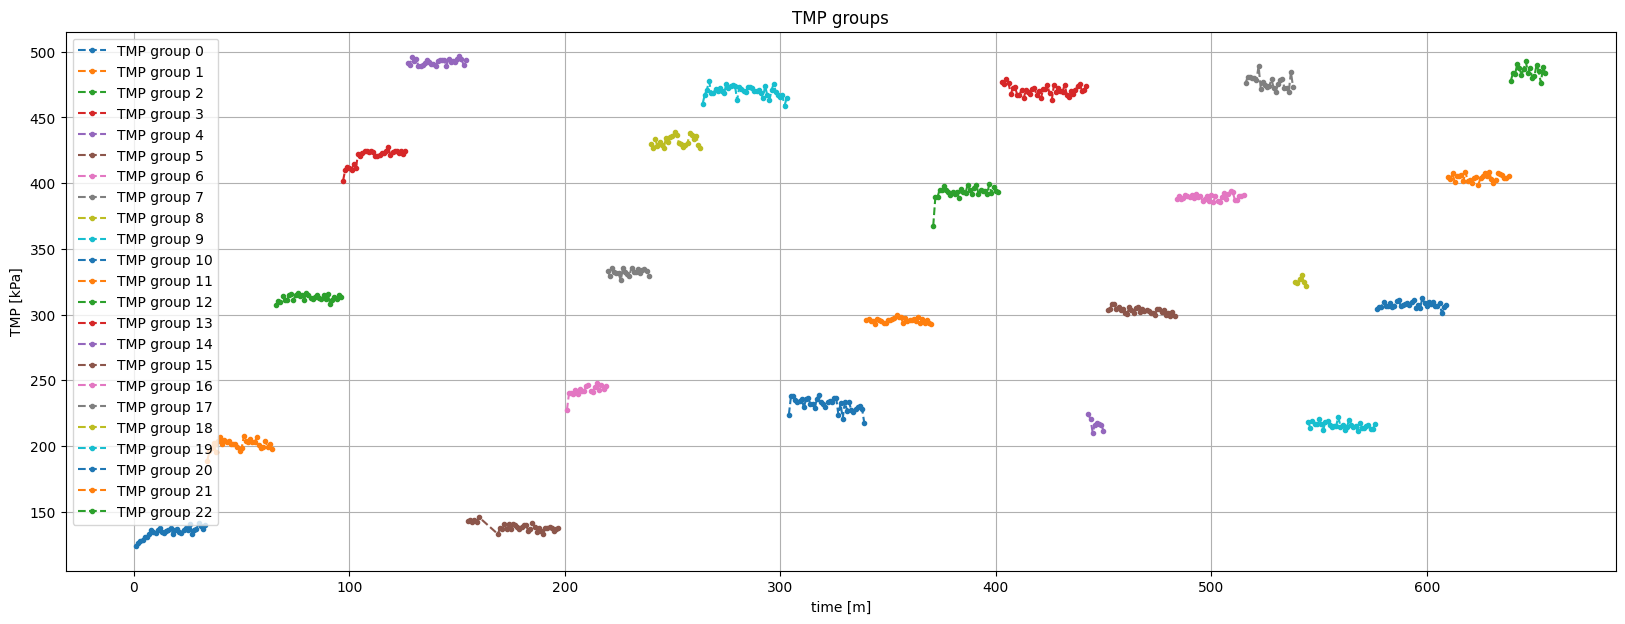

In [21]:
# print the TMP groups
group_by_cols = ['TMP group']
target_col = ['index', 'time [m]', 'TMP [kPa]']
display(pd.DataFrame(
    df[group_by_cols + target_col].groupby(group_by_cols).agg(
        ["min", "median", "max"])).reset_index(drop=True).drop(
        labels=[('index', 'median'), ('time [m]', 'median'), ('index', 'max'), ('time [m]','max')], axis=1))
# plot the TMP groups
y_dict = {}
TMP_group = df['TMP group'].drop_duplicates().dropna().values.astype(int)
for g in TMP_group :
    y_dict[f'TMP group {g}'] = df.apply(lambda x : x['TMP [kPa]'] if (x['TMP group'] == g) else np.nan, axis=1)
# if there are any too small groups
if (df['TMP group']).isna().any() : 
    y_dict[f'outliers (min group size: {MIN_OBSERVATIONS_PER_TMP_GROUP})'] = df.apply(
        lambda x : x['TMP [kPa]'] if np.isnan(x['TMP group']) else np.nan, axis=1)
title='TMP groups'
plot_time_series_1_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl='TMP [kPa]', #concentration_lines=conc_lines, 
    title=title, x_format=x_format, is_outlier=is_outlier)

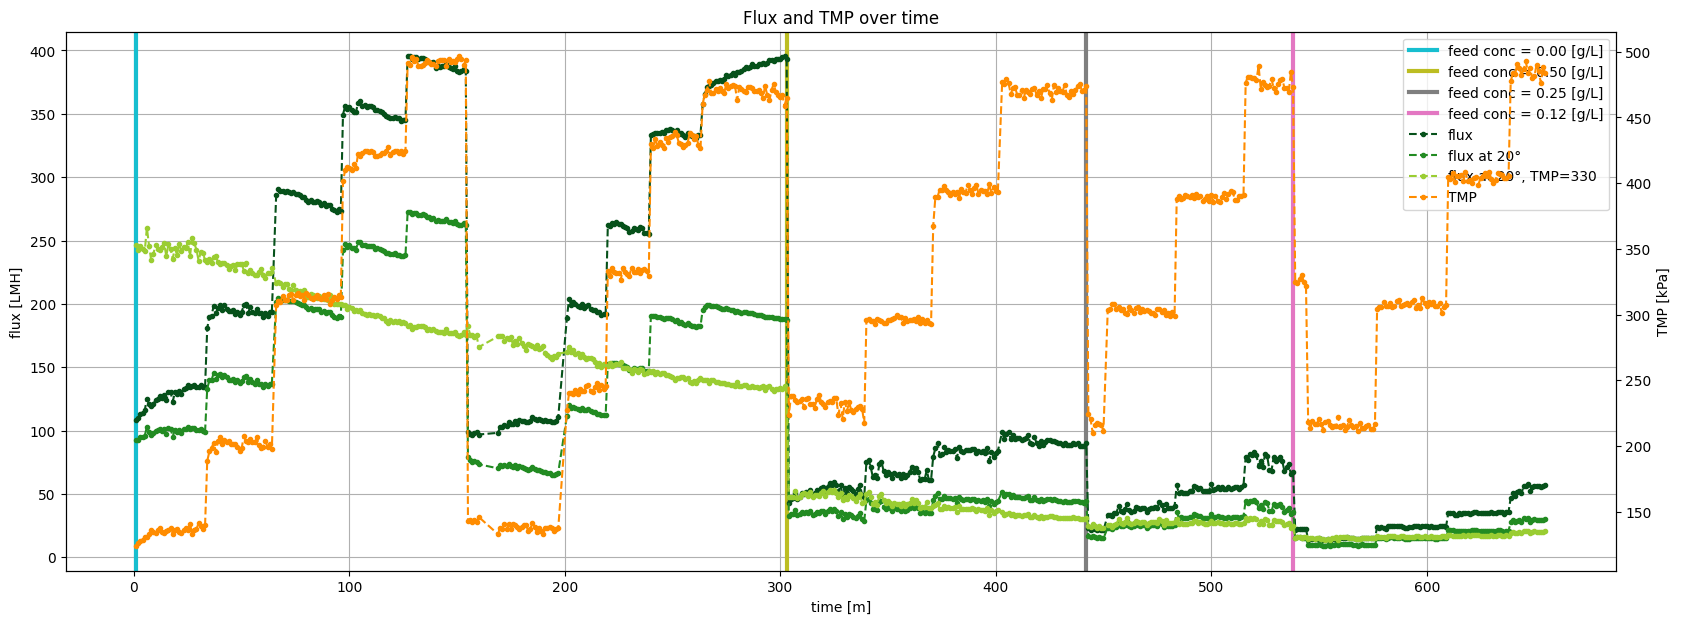

In [14]:
y_dict = {
    'flux' : df['flux [L/m^2h]'],
    'flux at 20°' : df['flux at 20° [L/m^2h]'],
    f'flux at 20°, TMP={CONST_TMP}' : df[f'flux at 20° TMP={CONST_TMP} [L/m^2h]'],
    'TMP'  : df['TMP [kPa]'],

}
title  = 'Flux and TMP over time'
ax1, ax2 = plot_time_series_2_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl='time [m]', 
    y_ax_lbl=['flux [LMH]', 'TMP [kPa]'], title=title, x_format=x_format, 
    secondary_y=['TMP'], concentration_lines=conc_lines, 
    color=['#06511A','forestgreen', 'yellowgreen','darkorange'], is_outlier=is_outlier)
#ax2.set_ylim(0,650)

(<Axes: xlabel='time [m]', ylabel='resistance [1/m]'>,
 <Axes: title={'center': 'Resistance and TMP over time'}, ylabel='TMP [kPa]'>)

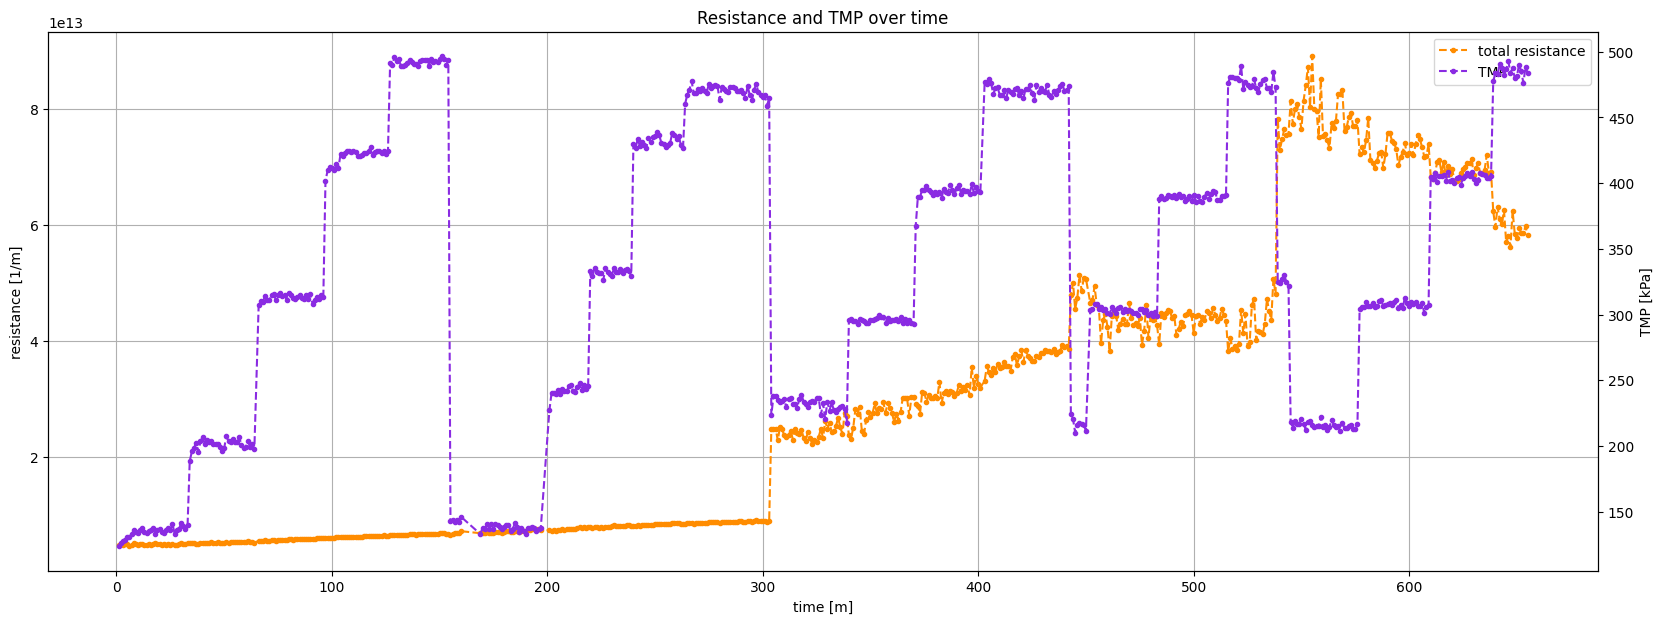

In [23]:
y_dict = {
    'total resistance'   : df['res tot [1/m]'],
    'TMP'                : df['TMP [kPa]'],
}
y_ax_lbl = ['resistance [1/m]', 'TMP [kPa]']
title    = 'Resistance and TMP over time'
plot_time_series_2_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, title=title, 
    x_format=x_format, secondary_y=['TMP'], is_outlier=is_outlier, color=['darkorange','blueviolet'])

(<Axes: xlabel='time [m]', ylabel='flux [L/m^2h]'>,
 <Axes: title={'center': 'Flux and Temperature over time'}, ylabel='temperature [°C]'>)

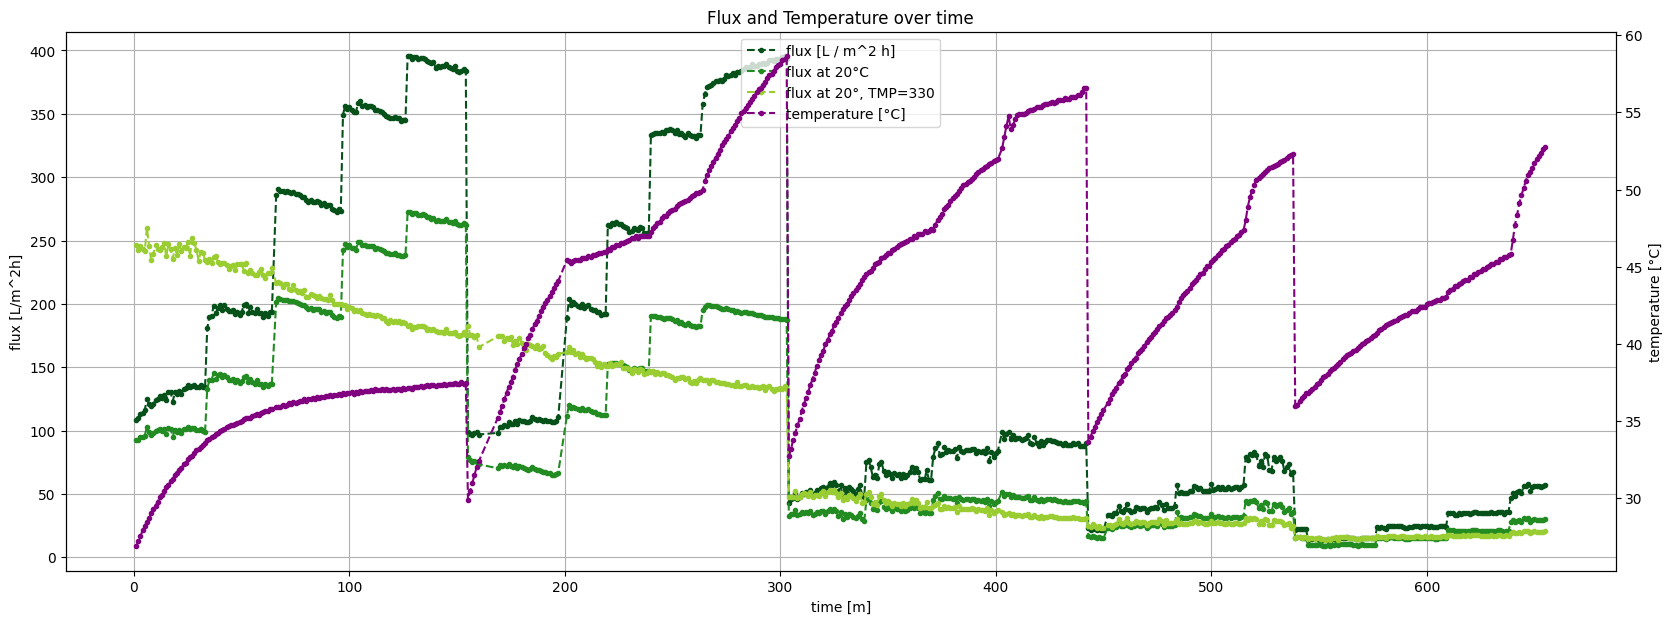

In [16]:
y_dict = {
    'flux [L / m^2 h]' : df['flux [L/m^2h]'],
    'flux at 20°C' : df['flux at 20° [L/m^2h]'],
    f'flux at 20°, TMP={CONST_TMP}' : df[f'flux at 20° TMP={CONST_TMP} [L/m^2h]'],
    'temperature [°C]' : df['temperature [°C]'],
}
y_ax_lbl = 'flux [LMH]'
title    = 'Flux and Temperature over time'
plot_time_series_2_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=['flux [L/m^2h]', 'temperature [°C]'], 
    title=title, x_format=x_format, secondary_y=['temperature [°C]'], loc='upper center', 
    color=['#06511A','forestgreen', 'yellowgreen','purple'], is_outlier=is_outlier)

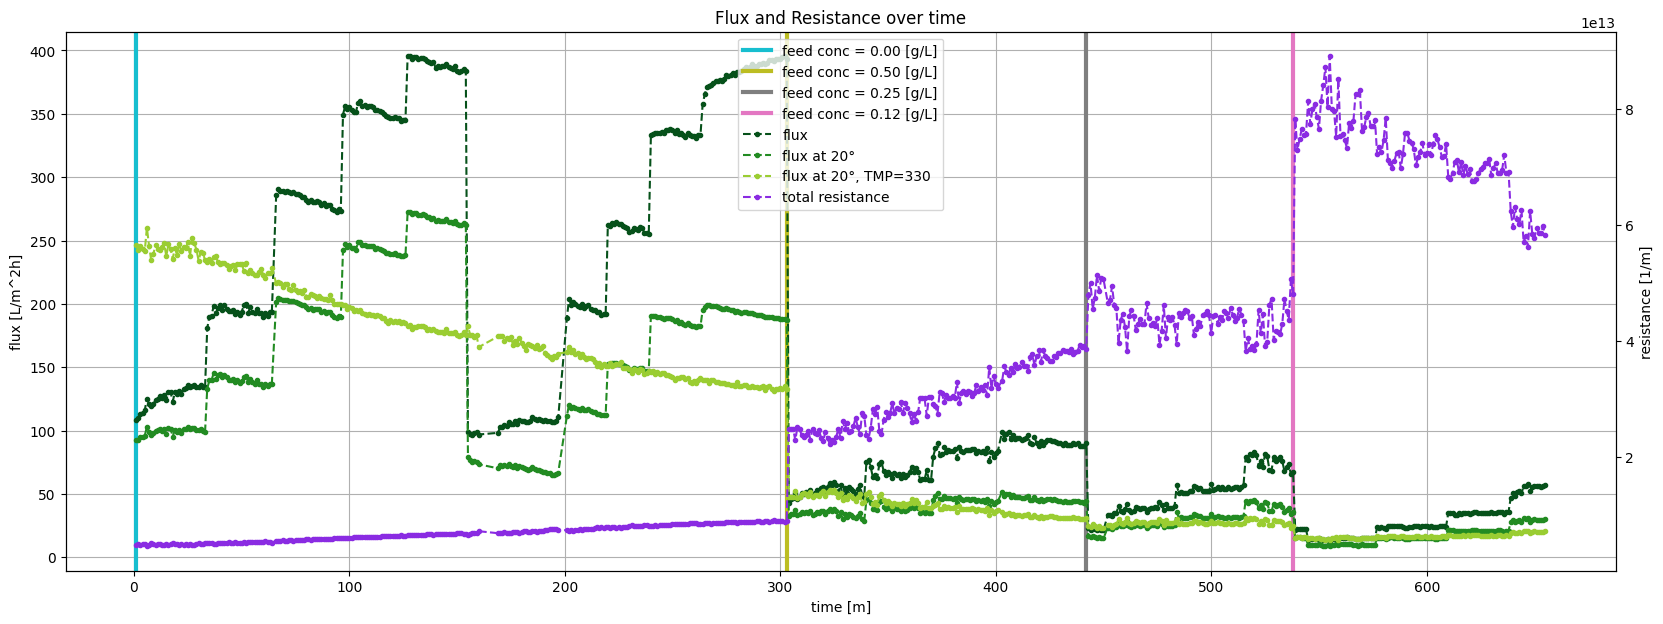

In [17]:
y_dict = {
    'flux' : df['flux [L/m^2h]'],
    'flux at 20°' : df['flux at 20° [L/m^2h]'],
    f'flux at 20°, TMP={CONST_TMP}' : df[f'flux at 20° TMP={CONST_TMP} [L/m^2h]'],
    'total resistance' : df['res tot [1/m]'],
}
y_ax_lbl = 'flux [LMH]'
title    = 'Flux and Resistance over time'
ax1, ax2 = plot_time_series_2_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl='time [m]', y_ax_lbl=['flux [L/m^2h]', 'resistance [1/m]'], 
    title=title, x_format=x_format, secondary_y=['total resistance', 'total resistance at 20°C'], 
    loc='upper center', color=['#06511A','forestgreen', 'yellowgreen','blueviolet'], 
    concentration_lines=conc_lines, is_outlier=is_outlier)

<module 'matplotlib.pyplot' from '/opt/venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

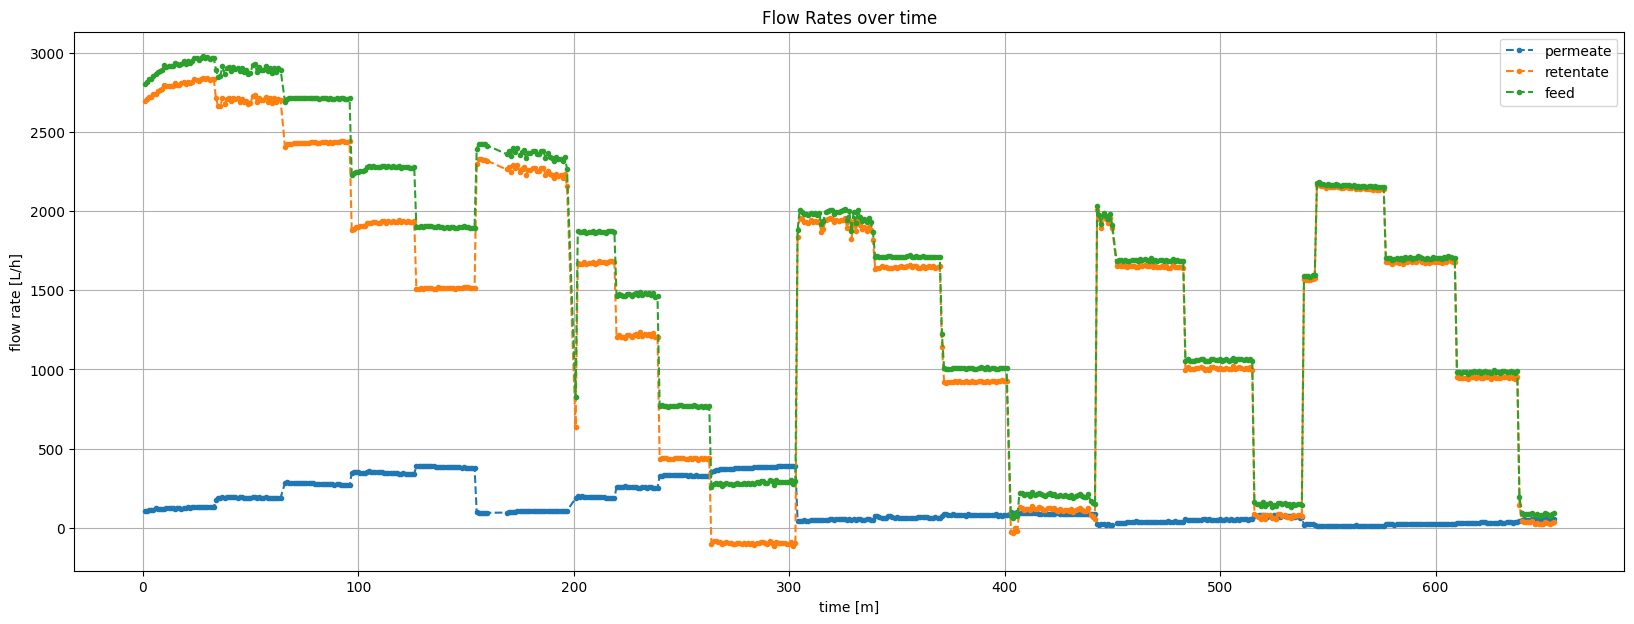

In [18]:
y_dict = {
    'permeate'  : df['flow permeate [L/h]'],
    'retentate' : df['flow retentate [L/h]'],
    'feed'      : df['flow feed [L/h]']
}
title='Flow Rates over time'
y_ax_lbl='flow rate [L/h]'
plot_time_series_1_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
    title=title, x_format=x_format, is_outlier=is_outlier)

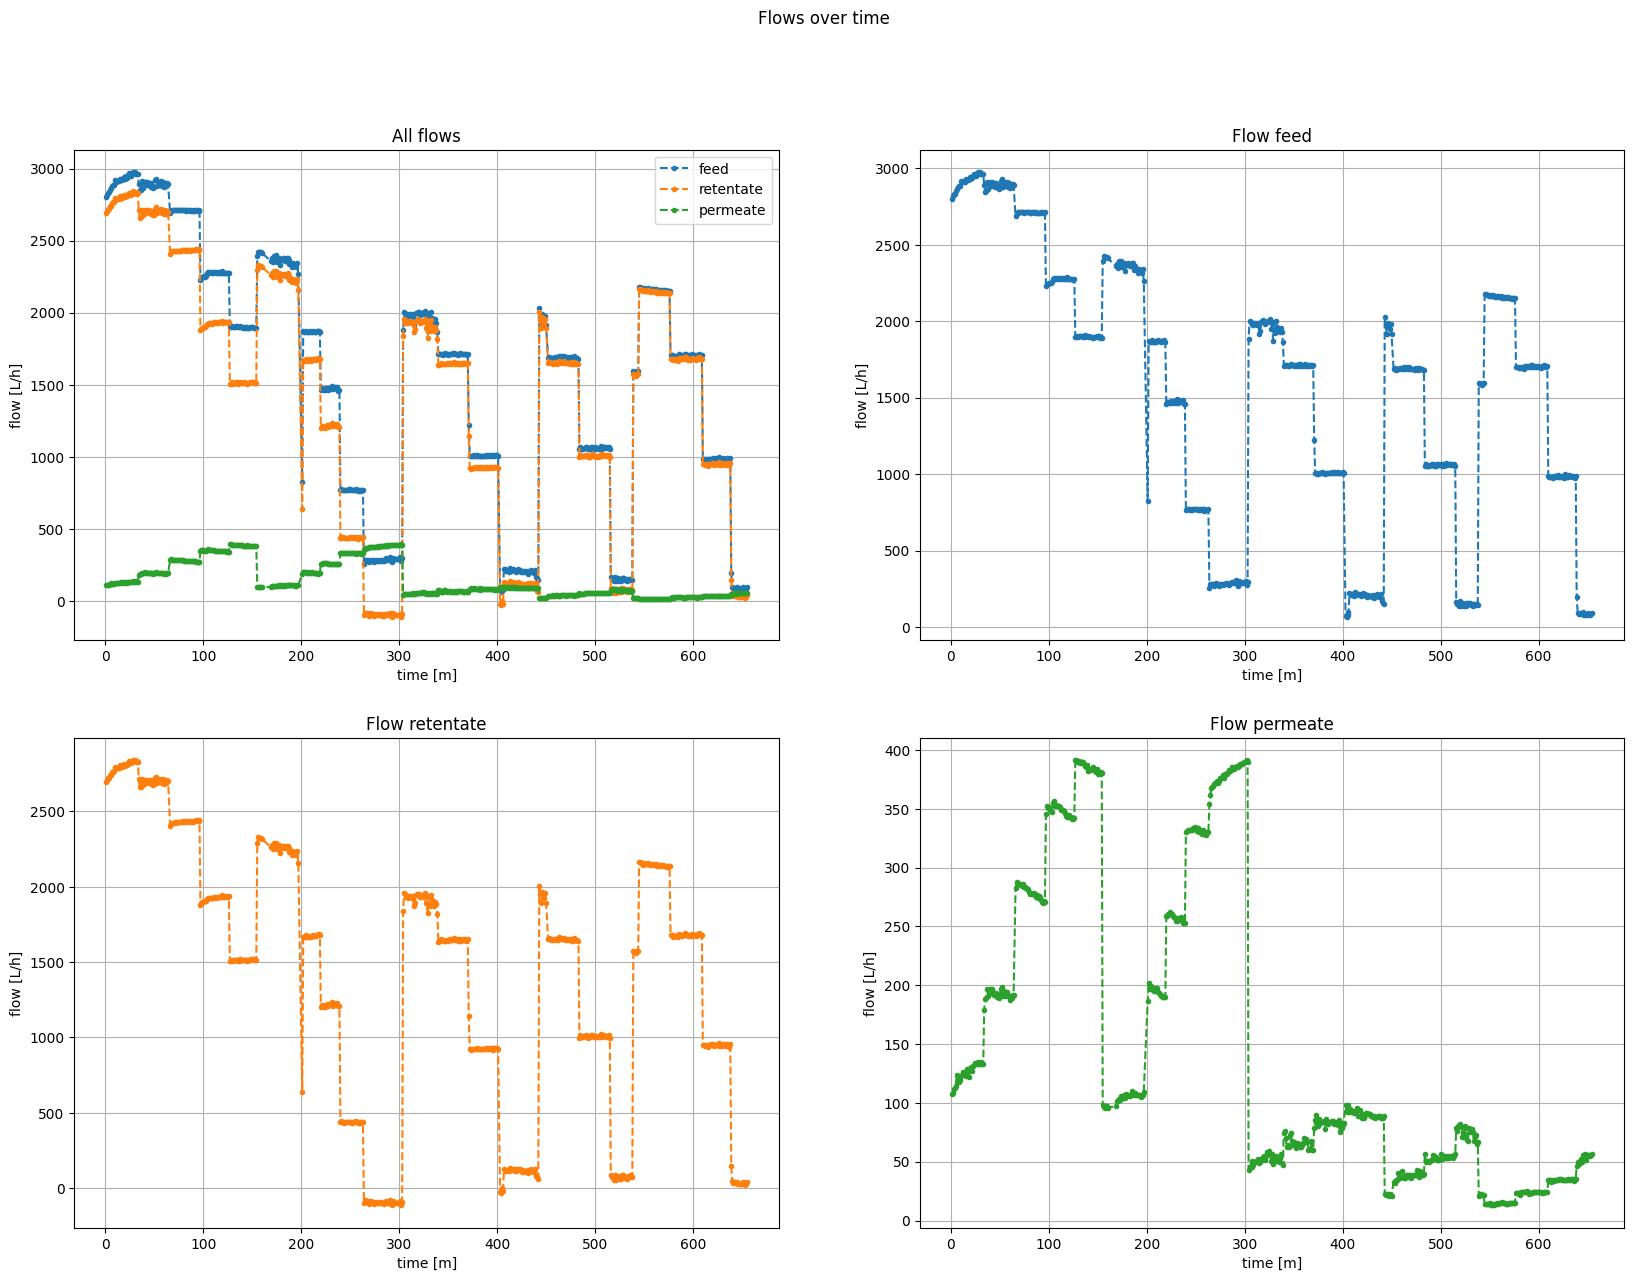

In [19]:
y_dict = {
    'feed'          : df['flow feed [L/h]'],
    'retentate'     : df['flow retentate [L/h]'],
    'permeate'      : df['flow permeate [L/h]']
}
y_ax_lbl = 'flow [L/h]'
rows = 2
cols = 2
idx = 0 if rows == 1 else (0, 0)
fig, axs = plot.subplots(rows, cols, figsize=(10*cols, 7*rows))
plot_time_series_1_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
    title="All flows", x_format=x_format, cur_ax=axs[idx], is_outlier=is_outlier)
i = 0
j = 1
for (name, col) in y_dict.items() :
    y_dict_tmp = {}
    y_dict_tmp[name] = col
    idx = j if rows == 1 else (i,j)
    plot_time_series_1_axis(
        x=df[x_axis], y_series=y_dict_tmp, x_ax_lbl=x_axis, 
        y_ax_lbl=y_ax_lbl, title=f"Flow {name}", x_format=x_format, 
        cur_ax=axs[idx], color=[COLOR_CYCLE[i*cols+j-1]], is_outlier=is_outlier)
    j = (j + 1) % cols
    if j == 0 :
        i += 1
plot.suptitle('Flows over time')
plot.show()


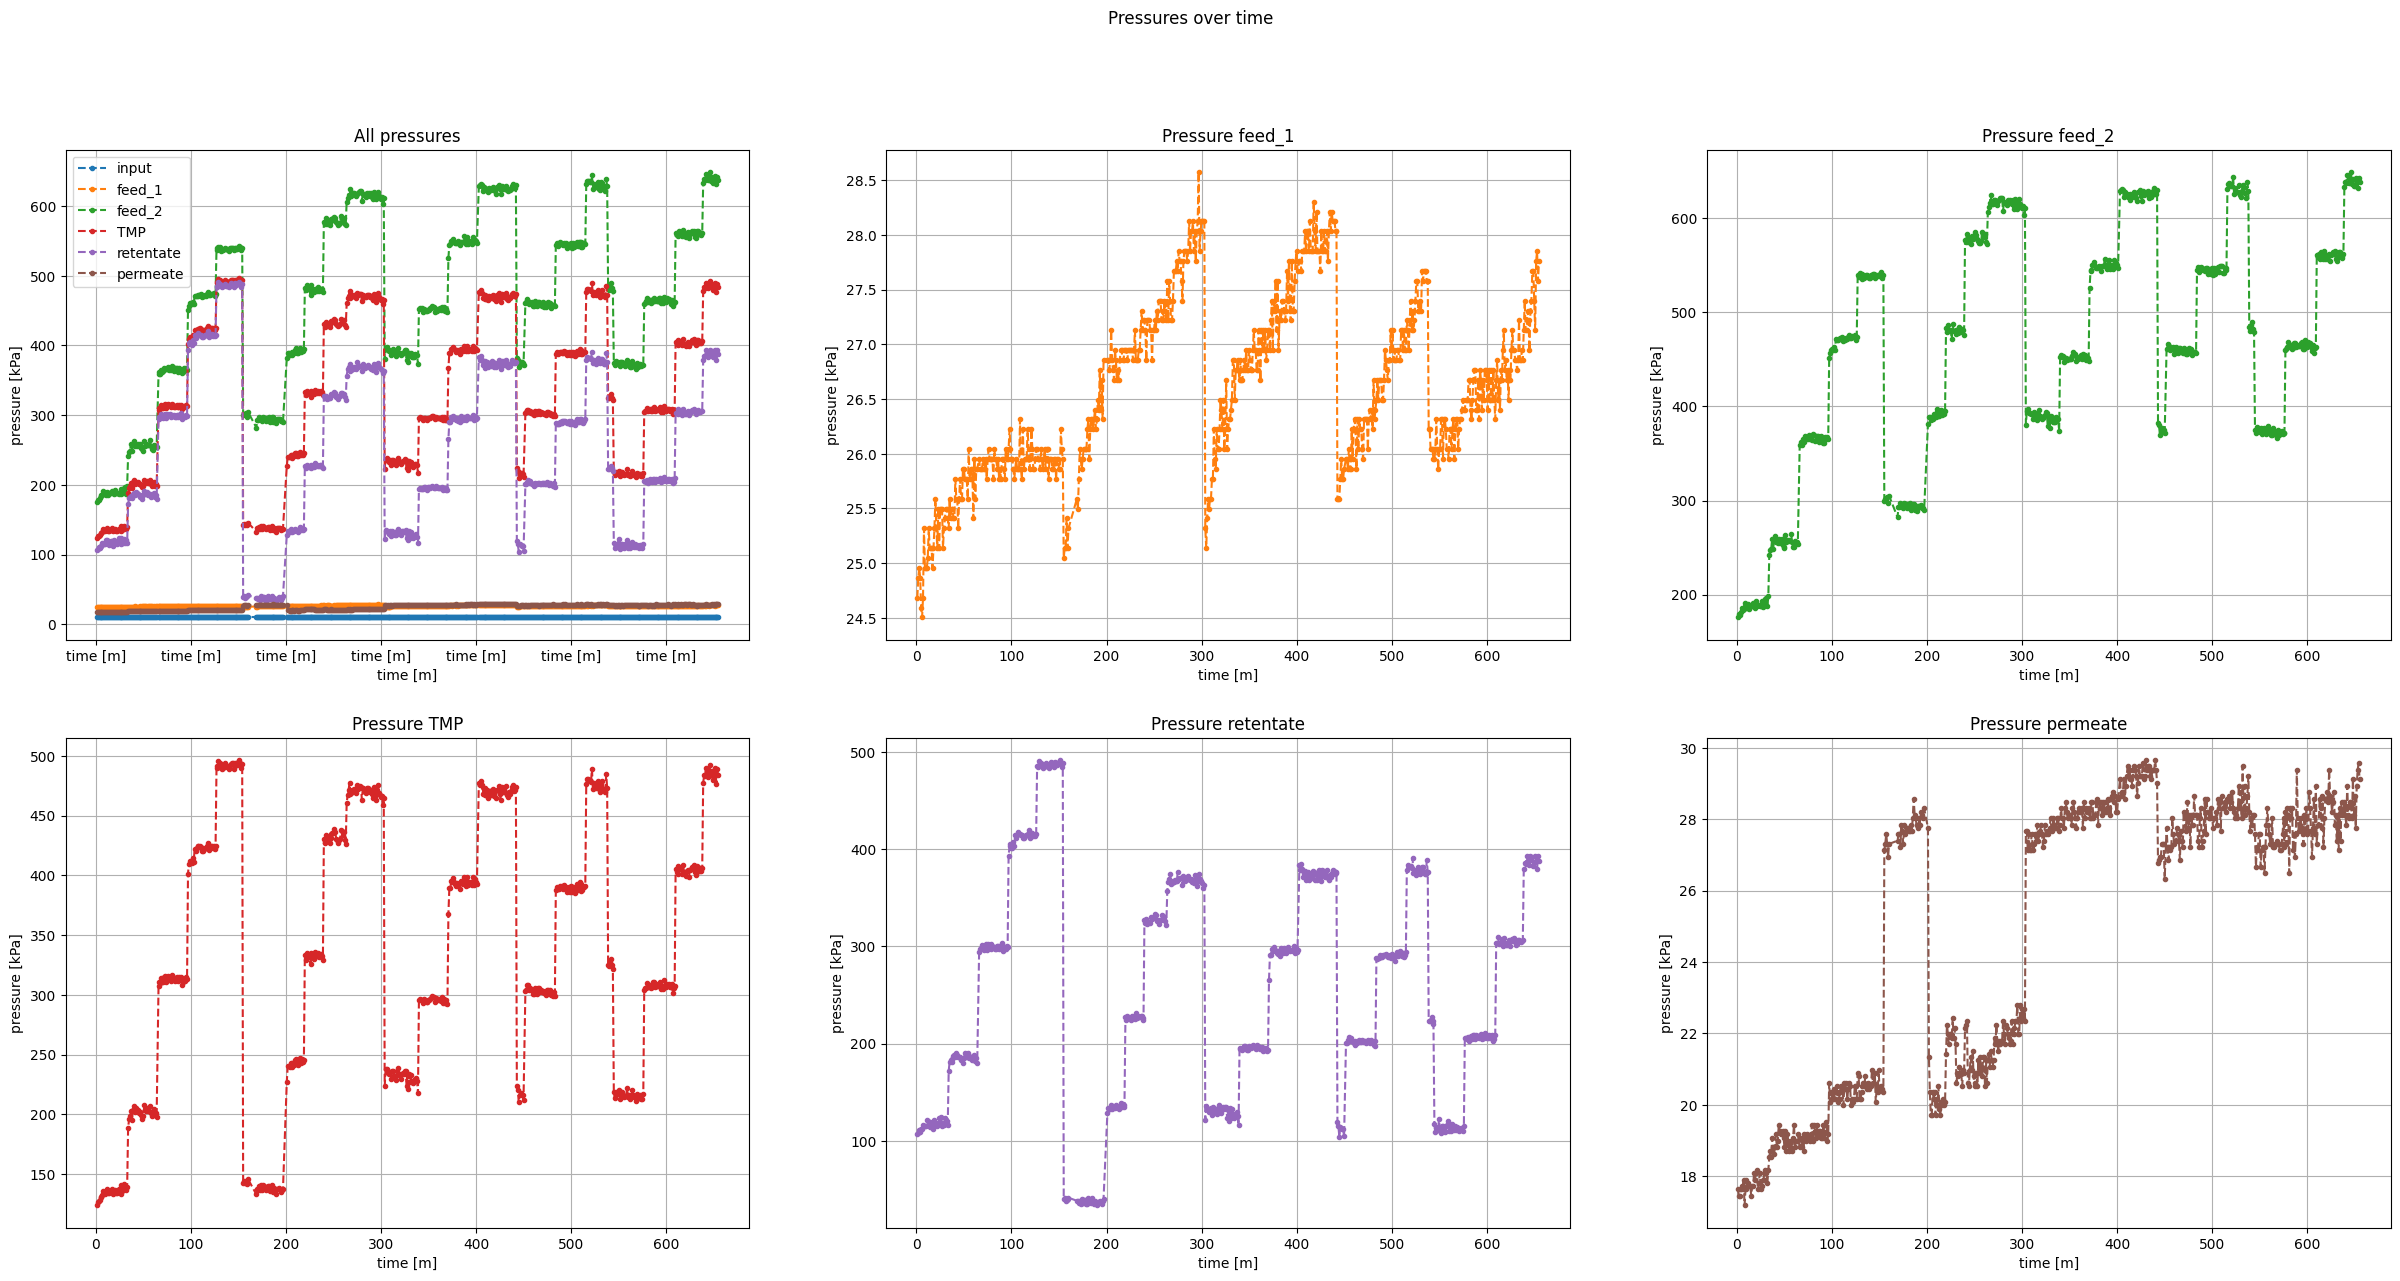

In [20]:
y_dict = {
    'input'     : df['prs input [kPa]'],
    'feed_1'    : df['prs feed_1 [kPa]'],
    'feed_2'    : df['prs feed_2 [kPa]'],
    'TMP'       : df['TMP [kPa]'],
    'retentate' : df['prs retentate [kPa]'],
    'permeate'  : df['prs permeate [kPa]'],
}
y_ax_lbl = 'pressure [kPa]'
rows = 2
cols = 3
fig, axs = plot.subplots(rows, cols, figsize=(10*cols, 7*rows))
plot_time_series_1_axis(
    x=df[x_axis], y_series=y_dict, x_ax_lbl=x_axis, y_ax_lbl=y_ax_lbl, 
    title="All pressures", x_format=x_axis, cur_ax=axs[0, 0], is_outlier=is_outlier)
i = 0
j = 1
for (name, col) in y_dict.items() :
    if (name != 'input') :
        y_dict_tmp = {}
        y_dict_tmp[name] = col
        plot_time_series_1_axis(
            x=df[x_axis], y_series=y_dict_tmp, x_ax_lbl=x_axis, 
            y_ax_lbl=y_ax_lbl, title=f"Pressure {name}", x_format=x_format, 
            cur_ax=axs[i, j], color=[COLOR_CYCLE[i*cols+j]], is_outlier=is_outlier)
        j = (j + 1) % cols
        if j == 0 :
            i += 1
plot.suptitle('Pressures over time')
plot.show()
